# Prepare Folder

In [60]:
import os
import shutil
#Folder with test runs to select from
tFolder = 'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/Raw_0/'
folder = 'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/' #folder where runs to aggregate are stored
topLevel_common = '500x4000' #filter first by this common string
output_name = 'Testing'
runs_common = {#'testP_ISdefault_500x4000_1000ref':'Default',
               'testP_IS_500x4000_dudv_1000refresh': 'Default_Fast',
               'testP_ISV_500x4000_dudv_1000S':'Voronoi_1000',
               'RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005': 'Ref1_3GD',
               }#strings that separate sub-folders, e.g. baseline, KL, SGM, Nvidia
file_search = 'events.out.tfevents' #find files with this string
folder_to_create = folder + output_name
runs_each = [sorted([j for j in os.listdir(tFolder) if i in j and topLevel_common in j],key=len) for i in runs_common.keys()]
runs_each

[['testP_IS_500x4000_dudv_1000refresh',
  'testP_IS_500x4000_dudv_1000refresh_1',
  'testP_IS_500x4000_dudv_1000refresh_2'],
 ['testP_ISV_500x4000_dudv_1000S',
  'testP_ISV_500x4000_dudv_1000S_0',
  'testP_ISV_500x4000_dudv_1000S_1',
  'testP_ISV_500x4000_dudv_1000S_2'],
 ['RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005',
  'RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005_0',
  'RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005_1',
  'RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005_2']]

In [61]:
min_runs = min([len(i) for i in runs_each])
runs_each = [i[0:min_runs] for i in runs_each]
events_each = [[list(filter(lambda x: file_search in x, os.listdir(tFolder+j)))[0] for j in i] for i in runs_each]
runs_each

[['testP_IS_500x4000_dudv_1000refresh',
  'testP_IS_500x4000_dudv_1000refresh_1',
  'testP_IS_500x4000_dudv_1000refresh_2'],
 ['testP_ISV_500x4000_dudv_1000S',
  'testP_ISV_500x4000_dudv_1000S_0',
  'testP_ISV_500x4000_dudv_1000S_1'],
 ['RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005',
  'RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005_0',
  'RefineParams1_500x4000_dudv_3GD_hnsw2_K25L11E1R200W50S0005_1']]

In [62]:
folder_to_create

'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing'

In [63]:
os.mkdir(folder_to_create)
for i in range(min_runs):
    os.mkdir(folder_to_create+f'/Run_{i}')
    for k,j in enumerate(runs_common.values()):
        os.mkdir(folder_to_create+f'/Run_{i}'+f'/{j}')
        shutil.copy(tFolder+runs_each[k][i]+'/'+events_each[k][i],
                    folder_to_create+f'/Run_{i}'+f'/{j}')


# Aggregate Files

## Defines

In [64]:
# MIT License
# Copyright (c) 2019 Sebastian Penhouet
# GitHub project: https://github.com/Spenhouet/tensorboard-aggregator
# ==============================================================================
"""Aggregates multiple tensorbaord runs"""

import ast
import argparse
import os
import re
from pathlib import Path

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorflow.core.util.event_pb2 import Event
import pdb

FOLDER_NAME = 'aggregates'
size = 100

def extract(dpath, subpath):
    scalar_accumulators = [EventAccumulator(str(dpath / dname / subpath), size_guidance = {'tensors':int(size)}).Reload(
    ).tensors for dname in os.listdir(dpath) if dname != FOLDER_NAME]

    #print(scalar_accumulators)
    #print([(dname,subpath) for dname in os.listdir(dpath) if dname != FOLDER_NAME])

    # Filter non event files
    scalar_accumulators = [scalar_accumulator for scalar_accumulator in scalar_accumulators if scalar_accumulator.Keys()]
    #print(scalar_accumulators)
    # Get and validate all scalar keys
    all_keys = [tuple([i for i in scalar_accumulator.Keys() if 'config/text_summary' not in i]) for scalar_accumulator in scalar_accumulators]
    print(all_keys)
    #pdb.set_trace()
    assert len(set(all_keys)) == 1, "All runs need to have the same scalar keys. There are mismatches in {}".format(all_keys)
    keys = all_keys[0]

    all_scalar_events_per_key = [[scalar_accumulator.Items(key) for scalar_accumulator in scalar_accumulators] for key in keys]

    # Get and validate all steps per key
    all_steps_per_key = [[tuple(scalar_event.step for scalar_event in scalar_events) for scalar_events in all_scalar_events]
                         for all_scalar_events in all_scalar_events_per_key]

    for i, all_steps in enumerate(all_steps_per_key):
        assert len(set(all_steps)) == 1, "For scalar {} the step numbering or count doesn't match. Step count for all runs: {}".format(
            keys[i], [len(steps) for steps in all_steps])

    steps_per_key = [all_steps[0] for all_steps in all_steps_per_key]

    # Get and average wall times per step per key
    wall_times_per_key = [np.mean([tuple(scalar_event.wall_time for scalar_event in scalar_events) for scalar_events in all_scalar_events], axis=0)
                          for all_scalar_events in all_scalar_events_per_key]

    # Get values per step per key
    try:
        values_per_key = [[[scalar_event.tensor_proto.float_val[0] for scalar_event in scalar_events] for scalar_events in all_scalar_events]
                      for all_scalar_events in all_scalar_events_per_key]
    except:
        print ([[[scalar_event.tensor_proto for scalar_event in scalar_events] for scalar_events in all_scalar_events]
                      for all_scalar_events in all_scalar_events_per_key])
    #pdb.set_trace()
    all_per_key = dict(zip(keys, zip(steps_per_key, wall_times_per_key, values_per_key)))

    return all_per_key


def aggregate_to_summary(dpath, aggregation_ops, extracts_per_subpath):
    for op in aggregation_ops:
        for subpath, all_per_key in extracts_per_subpath.items():
            path = dpath / FOLDER_NAME / op.__name__ / dpath.name / subpath
            aggregations_per_key = {key: (steps, wall_times, op(values, axis=0)) for key, (steps, wall_times, values) in all_per_key.items()}
            write_summary(path, aggregations_per_key)


def write_summary(dpath, aggregations_per_key):
    writer = tf.summary.create_file_writer(str(dpath))

    for key, (steps, wall_times, aggregations) in aggregations_per_key.items():
        for step, wall_time, aggregation in zip(steps, wall_times, aggregations):
            with writer.as_default():
                tf.summary.scalar(key, aggregation, step=step)
                writer.flush()
    #pdb.set_trace() #EventAccumulator(str(C:\Users\jacec\Documents\Test_Runs\512x16000\aggregates\mean\512x16000), size_guidance = {'tensors':0})

def aggregate_to_csv(dpath, aggregation_ops, extracts_per_subpath):
    for subpath, all_per_key in extracts_per_subpath.items():
        for key, (steps, wall_times, values) in all_per_key.items():
            aggregations = [op(values, axis=0) for op in aggregation_ops]
            write_csv(dpath, subpath, key, dpath.name, aggregations, steps, aggregation_ops, wall_times)


def get_valid_filename(s):
    s = str(s).strip().replace(' ', '_')
    return re.sub(r'(?u)[^-\w.]', '', s)


def write_csv(dpath, subpath, key, fname, aggregations, steps, aggregation_ops, wall_times):
    path = dpath / FOLDER_NAME

    if not path.exists():
        os.makedirs(path)

    file_name = get_valid_filename(key) + '-' + get_valid_filename(subpath) + '-' + fname + '.csv'
    aggregation_ops_names = [aggregation_op.__name__ for aggregation_op in aggregation_ops]
    df = pd.DataFrame(np.transpose(aggregations), index=steps, columns=aggregation_ops_names)
    df.insert(len(aggregation_ops_names), "wall_time", wall_times)
    df.to_csv(path / file_name, sep=';')


def aggregate(dpath, output, subpaths):
    name = dpath.name

    aggregation_ops = [np.mean, np.min, np.max, np.median, np.std, np.var]

    ops = {
        'summary': aggregate_to_summary,
        'csv': aggregate_to_csv
    }

    print("Started aggregation {}".format(name))

    extracts_per_subpath = {subpath: extract(dpath, subpath) for subpath in subpaths}

    ops.get(output)(dpath, aggregation_ops, extracts_per_subpath)

    print("Ended aggregation {}".format(name))


# if __name__ == '__main__':
#     def param_list(param):
#         p_list = ast.literal_eval(param)
#         if type(p_list) is not list:
#             raise argparse.ArgumentTypeError("Parameter {} is not a list".format(param))
#         return p_list

#     parser = argparse.ArgumentParser()
#     parser.add_argument("--path", type=str, help="main path for tensorboard files", default=os.getcwd())
#     parser.add_argument("--subpaths", type=param_list, help="subpath structures", default=['.'])
#     parser.add_argument("--output", type=str, help="aggregation can be saved as tensorboard file (summary) or as table (csv)", default='summary')
#     parser.add_argument("--size", type=int, help="# of samples", default=100)
#     args = parser.parse_args()

#     path = Path(args.path)

#     if not path.exists():
#         raise argparse.ArgumentTypeError("Parameter {} is not a valid path".format(path))

#     subpaths = [path / dname / subpath for subpath in args.subpaths for dname in os.listdir(path) if dname != FOLDER_NAME]
#     #print(subpaths)
#     for subpath in subpaths:
#         if not os.path.exists(subpath):
#             raise argparse.ArgumentTypeError("Parameter {} is not a valid path".format(subpath))

#     if args.output not in ['summary', 'csv']:
#         raise argparse.ArgumentTypeError("Parameter {} is not summary or csv".format(args.output))

#     aggregate(path, args.output, args.subpaths)


## Runs

In [65]:
def param_list(param):
    p_list = ast.literal_eval(param)
    if type(p_list) is not list:
        raise argparse.ArgumentTypeError("Parameter {} is not a list".format(param))
    return p_list
print(folder_to_create+'/')
path = Path(folder_to_create) # default os.getcwd()
print(path)
print(type(path))
print(os.getcwd())
args_subpaths = [v for k,v in runs_common.items()]
print(args_subpaths)
print(type(args_subpaths))
output = 'csv' #summary, csv

if not path.exists():
    raise argparse.ArgumentTypeError("Parameter {} is not a valid path".format(path))

subpaths = [path / dname / subpath for subpath in args_subpaths for dname in os.listdir(path) if dname != FOLDER_NAME]
print(subpaths)
for subpath in subpaths:
    if not os.path.exists(subpath):
        raise argparse.ArgumentTypeError("Parameter {} is not a valid path".format(subpath))

if output not in ['summary', 'csv']:
    raise argparse.ArgumentTypeError("Parameter {} is not summary or csv".format(output))

aggregate(path, output, args_subpaths)

C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/
C:\Users\jacec\OneDrive - stevens.edu\DATA\GraphZoom\aggregated_runs\Testing
<class 'pathlib.WindowsPath'>
c:\Users\jacec\OneDrive - stevens.edu\DATA\GraphZoom\Aggregator_Files
['Default_Fast', 'Voronoi_1000', 'Ref1_3GD']
<class 'list'>
[WindowsPath('C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/Run_0/Default_Fast'), WindowsPath('C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/Run_1/Default_Fast'), WindowsPath('C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/Run_2/Default_Fast'), WindowsPath('C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/Run_0/Voronoi_1000'), WindowsPath('C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/Run_1/Voronoi_1000'), WindowsPath('C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/Run_2/Voronoi_1000'), WindowsPath(

# Plot - Param

In [74]:
import pandas as pd
import os
import matplotlib.pyplot as plt

variablesKey = 'Validators'
variablesSplit = 'l2_relative_error_'
validatorsRename = {'validator':'r1.0','validator_2':'r0.85','validator_3':'r0.75'}
variablesID = 'validator'
#TODO get subfolders automatically
subfolders = [v for k,v in runs_common.items()]
print(subfolders)
legendNames = ['Uniform_1024','SGM-S-PINN_1024','MIS_1024','Uniform_4096']
legendNames = subfolders
# run aggregates with these subfoldetrs
#folder = 'C:/Users/jacec/Documents/Test_Runs/'
folder = folder_to_create
print(folder_to_create)
aggregates = [folder+'/aggregates/' for f in [''] if os.path.isdir(folder+f)]
#all results will be in /aggregates, separated by tags from subfolders
#find all validation files separated by subfolder
files = []

files = [[i+g for g in os.listdir(i) if g.endswith('.csv') and (variablesKey in g)] for i in aggregates]

files


['Default_Fast', 'Voronoi_1000', 'Ref1_3GD']
C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing


[['C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_nu-Default_Fast-Testing.csv',
  'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_nu-Ref1_3GD-Testing.csv',
  'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_nu-Voronoi_1000-Testing.csv',
  'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_p-Default_Fast-Testing.csv',
  'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_p-Ref1_3GD-Testing.csv',
  'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_p-Voronoi_1000-Testing.csv',
  'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggrega

In [75]:
#each aggregate becomes one dataframe
#extract common variable names (validator, validator_n, uvpvnu)
#load into df with descriptive columns, uses 'subfolder' name, validator name, variable name
dataframes = []
agNames = []
for aggregation in files:
    dfs = []
    agName = aggregation[0].split('/aggregates/')[0].split('/')[-1]
    for testName in subfolders:
        subtests = [csv for csv in aggregation if testName in csv]
        if not subtests:
            continue
        print(subtests)
        for k,i in enumerate(subtests):
            validatorName = i.split(variablesKey)[1].split(variablesSplit)[0]
            vv = i.split(variablesSplit)[1].split('-'+testName)[0]
            variableName = f'{testName}_{validatorsRename[validatorName]}_{vv}_'
            print(variableName)
            #df = pd.read_csv(i, index_col = 0, delimiter=';')
            df = pd.read_csv(i, delimiter=';')
            oldcols = df.keys()
            print(oldcols)
            #mapping = {i:variableName+i for i in oldcols[0:-1]}
            mapping = {'Unnamed: 0':variableName+'step'}
            if k == 0:
                mapping.update({'wall_time':testName+'_wall_time'})
            mapping.update({i:variableName+i for i in oldcols[1:-1]})
            print(mapping)
            df.rename(columns=mapping, inplace=True)
            newcols = df.keys()
            print(newcols)
            if k > 0:
                df.drop(columns='wall_time')
            dfs.append(df)
    df = pd.concat(dfs, axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy() #drop duplicates based on column name alone
    #append to dataframes list
    dataframes.append(df)
    agNames.append(agName)

['C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_nu-Default_Fast-Testing.csv', 'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_p-Default_Fast-Testing.csv', 'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_u-Default_Fast-Testing.csv', 'C:/Users/jacec/OneDrive - stevens.edu/DATA/GraphZoom/aggregated_runs/Testing/aggregates/Validatorsvalidatorl2_relative_error_v-Default_Fast-Testing.csv']
Default_Fast_Validator_nu_
Index(['Unnamed: 0', 'mean', 'min', 'max', 'median', 'std', 'var',
       'wall_time'],
      dtype='object')
{'Unnamed: 0': 'Default_Fast_Validator_nu_step', 'wall_time': 'Default_Fast_wall_time', 'mean': 'Default_Fast_Validator_nu_mean', 'min': 'Default_Fast_Validator_nu_min', 'max': 'Default_Fast_Validator_nu_max', 'median': 'Default_Fast_Validat

In [76]:
dataframes[0]
agNames
dataframes[0]


,Default_Fast_Validator_nu_step,Default_Fast_Validator_nu_mean,Default_Fast_Validator_nu_min,Default_Fast_Validator_nu_max,Default_Fast_Validator_nu_median,Default_Fast_Validator_nu_std,Default_Fast_Validator_nu_var,Default_Fast_wall_time,Default_Fast_Validator_p_step,Default_Fast_Validator_p_mean,...,Ref1_3GD_Validator_u_median,Ref1_3GD_Validator_u_std,Ref1_3GD_Validator_u_var,Ref1_3GD_Validator_v_step,Ref1_3GD_Validator_v_mean,Ref1_3GD_Validator_v_min,Ref1_3GD_Validator_v_max,Ref1_3GD_Validator_v_median,Ref1_3GD_Validator_v_std,Ref1_3GD_Validator_v_var
0,16000,1.208068,1.188034,1.227995,1.208177,0.016314,0.000266,1.713082e+09,16000,0.729987,...,0.620390,0.005260,2.766328e-05,16000,0.898907,0.890433,0.903183,0.903104,0.005992,3.590162e-05
1,70000,1.101155,1.075402,1.115325,1.112737,0.018241,0.000333,1.713085e+09,70000,0.881411,...,0.585107,0.003919,1.536155e-05,52000,0.826239,0.795452,0.876450,0.806816,0.035806,1.282104e-03
2,154000,0.883422,0.830982,0.920653,0.898630,0.038155,0.001456,1.713090e+09,154000,0.601500,...,0.505534,0.013946,1.944957e-04,70000,0.689109,0.655546,0.715785,0.695994,0.025070,6.285097e-04
3,160000,0.859425,0.803635,0.892970,0.881669,0.039718,0.001578,1.713091e+09,160000,0.625113,...,0.495401,0.010113,1.022699e-04,79000,0.666300,0.641694,0.695139,0.662068,0.022023,4.850147e-04
4,287000,0.518367,0.488880,0.566030,0.500191,0.034018,0.001157,1.713098e+09,287000,0.385762,...,0.439933,0.019060,3.632982e-04,154000,0.564480,0.524708,0.591573,0.577159,0.028732,8.255222e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2418000,0.177813,0.172573,0.181546,0.179321,0.003815,0.000015,1.713231e+09,2418000,1.028904,...,0.046177,0.000813,6.617787e-07,1890000,0.059067,0.058692,0.059328,0.059182,0.000272,7.391895e-08
96,2428000,0.177688,0.172381,0.181123,0.179562,0.003807,0.000014,1.713232e+09,2428000,1.028178,...,0.046285,0.000938,8.802672e-07,1936000,0.058834,0.058418,0.059123,0.058961,0.000301,9.077487e-08
97,2439000,0.177609,0.172532,0.180830,0.179464,0.003633,0.000013,1.713233e+09,2439000,1.028775,...,0.046177,0.000993,9.852891e-07,1944000,0.058904,0.058529,0.059161,0.059024,0.000271,7.370092e-08
98,2445000,0.177825,0.172585,0.181532,0.179358,0.003810,0.000015,1.713233e+09,2445000,1.029052,...,0.046301,0.000909,8.267588e-07,1959000,0.058792,0.058390,0.059026,0.058962,0.000286,8.179098e-08


[[('Default_Fast_Validator_nu_step', 'Default_Fast_Validator_nu_mean'), ('Voronoi_1000_Validator_nu_step', 'Voronoi_1000_Validator_nu_mean'), ('Ref1_3GD_Validator_nu_step', 'Ref1_3GD_Validator_nu_mean')]]
[('Default_Fast_Validator_nu_step', 'Default_Fast_Validator_nu_mean'), ('Voronoi_1000_Validator_nu_step', 'Voronoi_1000_Validator_nu_mean'), ('Ref1_3GD_Validator_nu_step', 'Ref1_3GD_Validator_nu_mean')]
[[('Default_Fast_Validator_nu_step', 'Default_Fast_wall_time', 'Default_Fast_Validator_nu_mean'), ('Voronoi_1000_Validator_nu_step', 'Voronoi_1000_wall_time', 'Voronoi_1000_Validator_nu_mean'), ('Ref1_3GD_Validator_nu_step', 'Ref1_3GD_wall_time', 'Ref1_3GD_Validator_nu_mean')]]
('Default_Fast_Validator_nu_step', 'Default_Fast_wall_time', 'Default_Fast_Validator_nu_mean')
## min
0.1761494477589925
--idxmin
58
-- loc
27.06444070650472
('Voronoi_1000_Validator_nu_step', 'Voronoi_1000_wall_time', 'Voronoi_1000_Validator_nu_mean')
## min
0.1768429676691691
--idxmin
52
-- loc
16.803099955187

C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3514748883.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tm.append(rawdat.min()[2])
C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3514748883.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(rawdat.min()[2])
C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3514748883.py:83: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tm.append(rawdat.idxmin()[2])
C:\Users\jacec\Ap

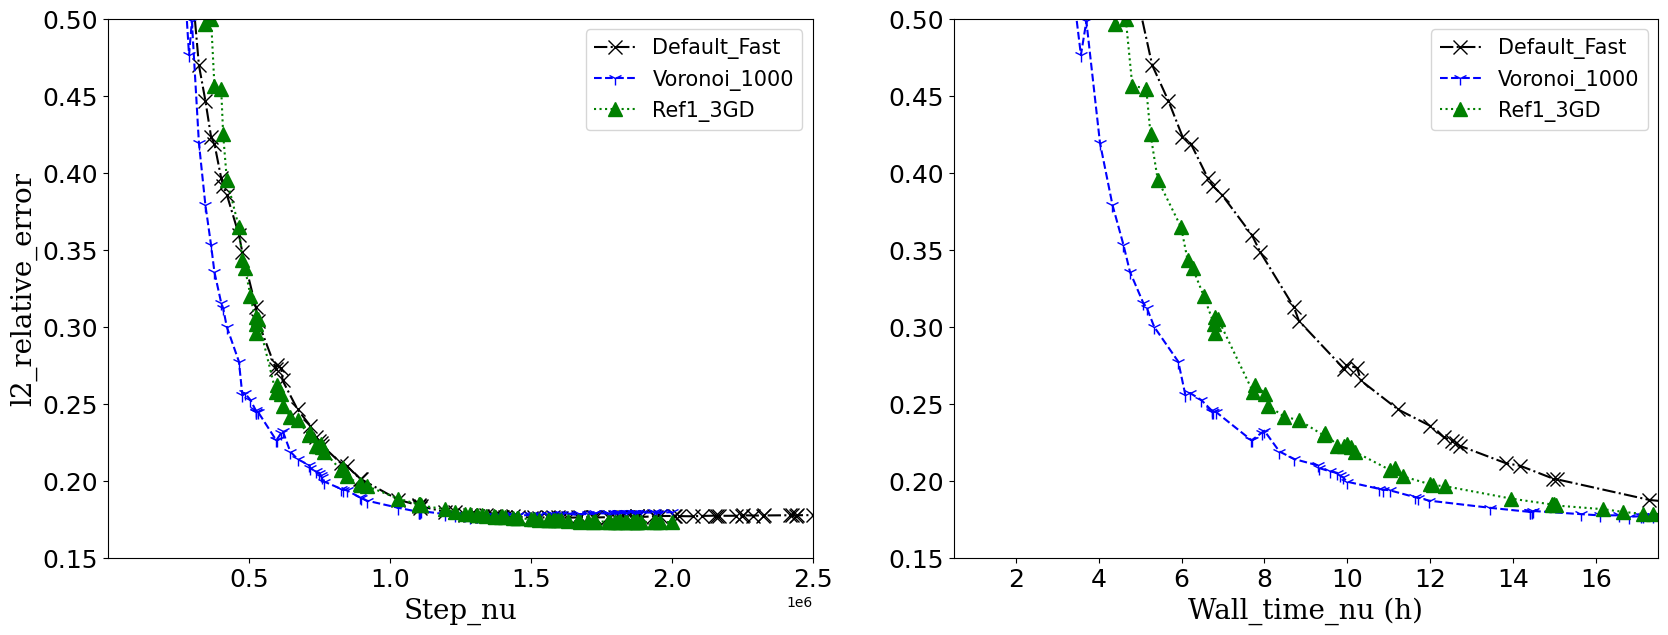

In [77]:
plotVar = 'nu'
manualLegend = ['Uniform_500_nu','SGM-PINN_500_nu','MIS_500_nu','Uniform_4000_nu']
manualLegend = legendNames
#plot step series p
plotVars_p_allValidators = [[(f'{i}_{j}_{plotVar}_step',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
print(plotVars_p_allValidators)
stepFilter = dataframes[0][f'{subfolders[0]}_Validator_nu_step'] >= 150000
def set_cycler(ax):
    ax.set_prop_cycle(plt.cycler('color', ['r', 'b', 'g', 'c'])+
                      plt.cycler('linestyle', ['-','--',':','-.'])+
                      plt.cycler('marker', ['.','*','^','x']))
    
def set_cycler(ax):
    ax.set_prop_cycle(plt.cycler('color', ['c', 'b', 'g', 'r'])+
                      plt.cycler('linestyle', ['-','--',':','-.'])+
                      plt.cycler('marker', ['x','1','^','x']))
    
def set_cycler(ax):
    ax.set_prop_cycle(plt.cycler('color', ['k', 'b', 'g', 'r'])+
                      plt.cycler('linestyle', ['-.','--',':','-'])+
                      plt.cycler('marker', ['x','1','^','x']))
    
font2 = {'family':'serif','color':'black','size':20}

legendloc = 'best'
legendfontsize = 15

for i in range(len(dataframes)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,7))
    #fig.suptitle(f'P step series for {agNames[i]}')
    plt.rc('legend', fontsize = 12)
    axes[0].set_ylabel('l2_relative_error', fontdict=font2)
    for k,j in enumerate(plotVars_p_allValidators):
        set_cycler(axes[k])
        print(j)
        axes[k].ticklabel_format(axis='x', style='sci',scilimits=(0,0))
        axes[k].tick_params(axis='both', labelsize=18)
        #print(f'{[(l,dataframes[i][j][l][99]) for l in dataframes[i][j]]}')
        for l in j:
            #print(l)
            rawdat = dataframes[i][list(l)]
            #print(rawdat)
            rawdat.plot(x=l[0],y=l[1],ax=axes[k],markersize=10)
        #dataframes[i][j][stepFilter].plot(x=j[0],ax=axes[k], markersize=10)
        axes[k].set_ylim((.15,.5))
        axes[k].set_xlim((.5,2.5e6))
        axes[k].set_xlabel('Step_'+str(l[0].split('_')[-2]), fontdict=font2)
        axes[k].legend(manualLegend, loc = legendloc, fontsize = legendfontsize)
    plotVars_p_allValidators = [[(f'{i}_wall_time',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
    for kk,j in enumerate(plotVars_p_allValidators):
        k = kk+1
        set_cycler(axes[k])
        axes[k].set_ylim((.15,.5))
        axes[k].set_xlim((.5,17.5))
        for l in j:
            rawdat = dataframes[i][list(l)]
            rawdat.loc[:,l[0]] = (rawdat.loc[:,l[0]] - rawdat.loc[0,l[0]])/60/60
            rawdat[rawdat[l[0]] >= .7].plot(x=l[0],y=l[1],ax=axes[k],markersize=10)
            axes[k].set_xlabel(f'Wall_time_{plotVar} (h)', fontdict=font2)
            axes[k].ticklabel_format(axis='x', style='plain',scilimits=(0,0)) #whats the code for numeric? 
            #axes[k].ticklabel_format(axis='x', style='sci',scilimits=(0,0)) is for sci, but not for numeric
            #axes[k].ticklabel_format(axis='x', style='plain',scilimits=(0,0)) 
            axes[k].tick_params(axis='both', labelsize=18)
            #print(l)
            time = [(q) for q in dataframes[i][l[0]]]
            #print(f'{(time[-1]-time[1])/60/60}')
        axes[k].legend(manualLegend, loc = legendloc, fontsize = legendfontsize)

plotVars_p_allValidators = [[(f'{i}_{j}_{plotVar}_step',f'{i}_wall_time',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
print(plotVars_p_allValidators)
for i in range(len(dataframes)):
    for k,j in enumerate(plotVars_p_allValidators):
        minimums = []
        for l in j:
            print(l)
            tm = []
            rawdat = dataframes[i][list(l)]
            rawdat.loc[:,l[1]] = (rawdat.loc[:,l[1]] - rawdat.loc[0,l[1]])/60/60
            print('## min')
            tm.append(rawdat.min()[2])
            print(rawdat.min()[2])
            print('--idxmin')
            tm.append(rawdat.idxmin()[2])
            print(rawdat.idxmin()[2])
            print('-- loc')
            tm.append(rawdat.loc[rawdat.idxmin()[2],l[1]])
            print(rawdat.loc[rawdat.idxmin()[2],l[1]])
            minimums.append(tm)
        print(minimums)

[[('Default_Fast_Validator_u_step', 'Default_Fast_Validator_u_mean'), ('Voronoi_1000_Validator_u_step', 'Voronoi_1000_Validator_u_mean'), ('Ref1_3GD_Validator_u_step', 'Ref1_3GD_Validator_u_mean')]]
[[('Default_Fast_Validator_u_step', 'Default_Fast_wall_time', 'Default_Fast_Validator_u_mean'), ('Voronoi_1000_Validator_u_step', 'Voronoi_1000_wall_time', 'Voronoi_1000_Validator_u_mean'), ('Ref1_3GD_Validator_u_step', 'Ref1_3GD_wall_time', 'Ref1_3GD_Validator_u_mean')]]
('Default_Fast_Validator_u_step', 'Default_Fast_wall_time', 'Default_Fast_Validator_u_mean')
## min
0.0473821138342221
--idxmin
40
-- loc
21.977170533802774
('Voronoi_1000_Validator_u_step', 'Voronoi_1000_wall_time', 'Voronoi_1000_Validator_u_mean')
## min
0.048019861181577
--idxmin
50
-- loc
16.094828833407824
('Ref1_3GD_Validator_u_step', 'Ref1_3GD_wall_time', 'Ref1_3GD_Validator_u_mean')
## min
0.0457184587915738
--idxmin
95
-- loc
25.848921997613377
[[0.0473821138342221, 40, 21.977170533802774], [0.048019861181577, 50,

C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3031894183.py:64: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tm.append(rawdat.min()[2])
C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3031894183.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(rawdat.min()[2])
C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3031894183.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tm.append(rawdat.idxmin()[2])
C:\Users\jacec\Ap

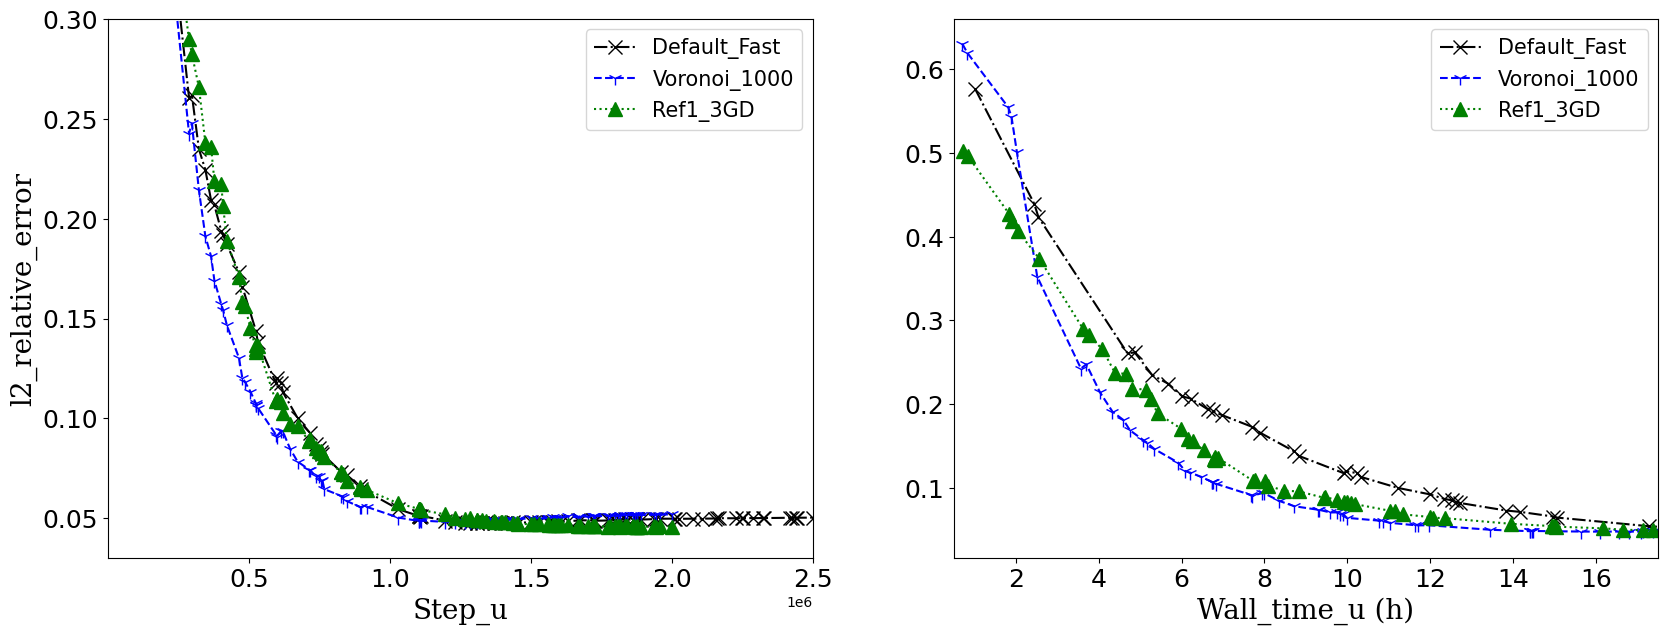

In [79]:
plotVar = 'u'
manualLegend = ['Uniform_500_u','SGM-PINN_500_u','MIS_500_u','Uniform_4000_u']
manualLegend = legendNames
#plot step series u
plotVars_p_allValidators = [[(f'{i}_{j}_{plotVar}_step',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
print(plotVars_p_allValidators)
    
font2 = {'family':'serif','color':'black','size':20}


for i in range(len(dataframes)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,7))
    #fig.suptitle(f'P step series for {agNames[i]}')
    plt.rc('legend', fontsize = 12)
    axes[0].set_ylabel('l2_relative_error', fontdict=font2)
    for k,j in enumerate(plotVars_p_allValidators):
        set_cycler(axes[k])
        #print(j)
        axes[k].ticklabel_format(axis='x', style='sci',scilimits=(0,0))
        axes[k].tick_params(axis='both', labelsize=18)
        #print(f'{[(l,dataframes[i][j][l][99]) for l in dataframes[i][j]]}')
        for l in j:
            #print(l)
            rawdat = dataframes[i][list(l)]
            #print(rawdat)
            rawdat.plot(x=l[0],y=l[1],ax=axes[k],markersize=10)
        #dataframes[i][j][stepFilter].plot(x=j[0],ax=axes[k], markersize=10)
        axes[k].set_ylim((.03,.3))
        axes[k].set_xlim((.5,2.5e6))
        #axes[k].set_xlabel(l[0].split('_')[0]+str(l[0].split('_')[-3:-1]), fontdict=font2)
        axes[k].set_xlabel('Step_'+str(l[0].split('_')[-2]), fontdict=font2)
        axes[k].legend(manualLegend, loc = legendloc, fontsize = legendfontsize)
    plotVars_p_allValidators = [[(f'{i}_wall_time',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
    for kk,j in enumerate(plotVars_p_allValidators):
        k = kk+1
        set_cycler(axes[k])
        #axes[k].set_ylim((.15,.5))
        axes[k].set_xlim((.5,17.5))
        for l in j:
            rawdat = dataframes[i][list(l)]
            rawdat.loc[:,l[0]] = (rawdat.loc[:,l[0]] - rawdat.loc[0,l[0]])/60/60
            rawdat[rawdat[l[0]] >= .7].plot(x=l[0],y=l[1],ax=axes[k],markersize=10)
            axes[k].set_xlabel(f'Wall_time_{plotVar} (h)', fontdict=font2)
            axes[k].ticklabel_format(axis='x', style='plain',scilimits=(0,0)) #whats the code for numeric? 
            #axes[k].ticklabel_format(axis='x', style='sci',scilimits=(0,0)) is for sci, but not for numeric
            #axes[k].ticklabel_format(axis='x', style='plain',scilimits=(0,0)) 
            axes[k].tick_params(axis='both', labelsize=18)
            #print(l)
            time = [(q) for q in dataframes[i][l[0]]]
            #print(f'{(time[-1]-time[1])/60/60}')
        axes[k].legend(manualLegend, loc = legendloc, fontsize = legendfontsize)

plotVars_p_allValidators = [[(f'{i}_{j}_{plotVar}_step',f'{i}_wall_time',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
print(plotVars_p_allValidators)
for i in range(len(dataframes)):
    for k,j in enumerate(plotVars_p_allValidators):
        minimums = []
        for l in j:
            print(l)
            tm = []
            rawdat = dataframes[i][list(l)]
            rawdat.loc[:,l[1]] = (rawdat.loc[:,l[1]] - rawdat.loc[0,l[1]])/60/60
            print('## min')
            tm.append(rawdat.min()[2])
            print(rawdat.min()[2])
            print('--idxmin')
            tm.append(rawdat.idxmin()[2])
            print(rawdat.idxmin()[2])
            print('-- loc')
            tm.append(rawdat.loc[rawdat.idxmin()[2],l[1]])
            print(rawdat.loc[rawdat.idxmin()[2],l[1]])
            minimums.append(tm)
        print(minimums)

##find first point less than min of others.        
# meanFilter = dataframes[0][f'SPADE_500_Validator_u_mean'] <= minimums[-1][0]
# rawdat = dataframes[0][['SPADE_500_wall_time',f'SPADE_500_Validator_u_mean']]
# rawdat.loc[:,'SPADE_500_wall_time'] = (rawdat.loc[:,'SPADE_500_wall_time'] - rawdat.loc[0,'SPADE_500_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)

# meanFilter = dataframes[0][f'SPADE_500_Validator_u_mean'] <= minimums[-2][0]
# rawdat = dataframes[0][['SPADE_500_wall_time',f'SPADE_500_Validator_u_mean']]
# rawdat.loc[:,'SPADE_500_wall_time'] = (rawdat.loc[:,'SPADE_500_wall_time'] - rawdat.loc[0,'SPADE_500_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)

# meanFilter = dataframes[0][f'MIS_500_Validator_u_mean'] <= minimums[-1][0]
# rawdat = dataframes[0][['MIS_500_wall_time',f'MIS_500_Validator_u_mean']]
# rawdat.loc[:,'MIS_500_wall_time'] = (rawdat.loc[:,'MIS_500_wall_time'] - rawdat.loc[0,'MIS_500_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)

[[('Default_Fast_Validator_v_step', 'Default_Fast_Validator_v_mean'), ('Voronoi_1000_Validator_v_step', 'Voronoi_1000_Validator_v_mean'), ('Ref1_3GD_Validator_v_step', 'Ref1_3GD_Validator_v_mean')]]
[('Default_Fast_Validator_v_step', 'Default_Fast_Validator_v_mean'), ('Voronoi_1000_Validator_v_step', 'Voronoi_1000_Validator_v_mean'), ('Ref1_3GD_Validator_v_step', 'Ref1_3GD_Validator_v_mean')]
('Default_Fast_Validator_v_step', 'Default_Fast_Validator_v_mean')
    Default_Fast_Validator_v_step  Default_Fast_Validator_v_mean
0                           16000                       0.862048
1                           70000                       0.728050
2                          154000                       0.539551
3                          160000                       0.523568
4                          287000                       0.313505
..                            ...                            ...
95                        2418000                       0.062596
96               

C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3105640545.py:65: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tm.append(rawdat.min()[2])
C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3105640545.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(rawdat.min()[2])
C:\Users\jacec\AppData\Local\Temp\ipykernel_3040\3105640545.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tm.append(rawdat.idxmin()[2])
C:\Users\jacec\Ap

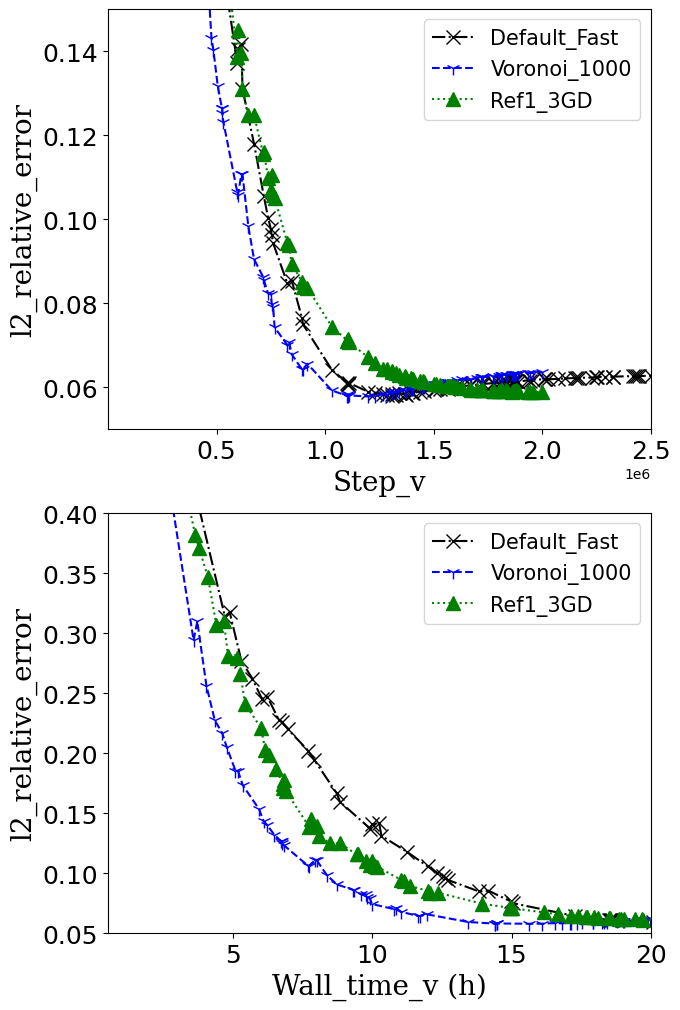

In [82]:
plotVar = 'v'
manualLegend = ['Uniform_500_v','SGM-PINN_500_v','MIS_500_v','Uniform_4000_v']
manualLegend = legendNames
#plot step series v
plotVars_p_allValidators = [[(f'{i}_{j}_{plotVar}_step',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
print(plotVars_p_allValidators)
    
font2 = {'family':'serif','color':'black','size':20}


for i in range(len(dataframes)):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (7,12))
    #fig.suptitle(f'P step series for {agNames[i]}')
    plt.rc('legend', fontsize = 12)
    axes[0].set_ylabel('l2_relative_error', fontdict=font2)
    for k,j in enumerate(plotVars_p_allValidators):
        set_cycler(axes[k])
        print(j)
        axes[k].ticklabel_format(axis='x', style='sci',scilimits=(0,0))
        axes[k].tick_params(axis='both', labelsize=18)
        #print(f'{[(l,dataframes[i][j][l][99]) for l in dataframes[i][j]]}')
        for l in j:
            print(l)
            rawdat = dataframes[i][list(l)]
            print(rawdat)
            rawdat.plot(x=l[0],y=l[1],ax=axes[k],markersize=10)
        #dataframes[i][j][stepFilter].plot(x=j[0],ax=axes[k], markersize=10)
        axes[k].set_ylim((.05,.15))
        axes[k].set_xlim((.5,2.5e6))
        #axes[k].set_xlabel(l[0].split('_')[0]+str(l[0].split('_')[-3:-1]), fontdict=font2)
        axes[k].set_xlabel('Step_'+str(l[0].split('_')[-2]), fontdict=font2)
        axes[k].legend(manualLegend, loc = legendloc, fontsize = legendfontsize)
    plotVars_p_allValidators = [[(f'{i}_wall_time',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
    for kk,j in enumerate(plotVars_p_allValidators):
        k = kk+1
        axes[k].set_ylabel('l2_relative_error', fontdict=font2)
        set_cycler(axes[k])
        axes[k].set_ylim((.05,.4))
        axes[k].set_xlim((.5,20))
        for l in j:
            rawdat = dataframes[i][list(l)]
            rawdat.loc[:,l[0]] = (rawdat.loc[:,l[0]] - rawdat.loc[0,l[0]])/60/60
            rawdat[rawdat[l[0]] >= .7].plot(x=l[0],y=l[1],ax=axes[k],markersize=10)
            axes[k].set_xlabel(f'Wall_time_{plotVar} (h)', fontdict=font2)
            axes[k].ticklabel_format(axis='x', style='plain',scilimits=(0,0)) #whats the code for numeric? 
            #axes[k].ticklabel_format(axis='x', style='sci',scilimits=(0,0)) is for sci, but not for numeric
            #axes[k].ticklabel_format(axis='x', style='plain',scilimits=(0,0)) 
            axes[k].tick_params(axis='both', labelsize=18)
            print(l)
            time = [(q) for q in dataframes[i][l[0]]]
            print(f'{(time[-1]-time[1])/60/60}')
        axes[k].legend(manualLegend, loc = legendloc, fontsize = legendfontsize)

plotVars_p_allValidators = [[(f'{i}_{j}_{plotVar}_step',f'{i}_wall_time',f'{i}_{j}_{plotVar}_mean') for i in subfolders] for j in validatorsRename.values()]
print(plotVars_p_allValidators)
for i in range(len(dataframes)):
    for k,j in enumerate(plotVars_p_allValidators):
        minimums = []
        for l in j:
            print(l)
            tm = []
            rawdat = dataframes[i][list(l)]
            rawdat.loc[:,l[1]] = (rawdat.loc[:,l[1]] - rawdat.loc[0,l[1]])/60/60
            print('## min')
            tm.append(rawdat.min()[2])
            print(rawdat.min()[2])
            print('--idxmin')
            tm.append(rawdat.idxmin()[2])
            print(rawdat.idxmin()[2])
            print('-- loc')
            tm.append(rawdat.loc[rawdat.idxmin()[2],l[1]])
            print(rawdat.loc[rawdat.idxmin()[2],l[1]])
            minimums.append(tm)
        print(minimums)

####find first point less than min of others.        

# meanFilter = dataframes[0][f'SPADE_500_Validator_{plotVar}_mean'] <= minimums[-1][0]
# rawdat = dataframes[0][['SPADE_500_wall_time',f'SPADE_500_Validator_{plotVar}_mean']]
# rawdat.loc[:,'SPADE_500_wall_time'] = (rawdat.loc[:,'SPADE_500_wall_time'] - rawdat.loc[0,'SPADE_500_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)

# meanFilter = dataframes[0][f'SPADE_500_Validator_{plotVar}_mean'] <= minimums[-2][0]
# rawdat = dataframes[0][['SPADE_500_wall_time',f'SPADE_500_Validator_{plotVar}_mean']]
# rawdat.loc[:,'SPADE_500_wall_time'] = (rawdat.loc[:,'SPADE_500_wall_time'] - rawdat.loc[0,'SPADE_500_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)

# meanFilter = dataframes[0][f'MIS_500_Validator_{plotVar}_mean'] <= minimums[-1][0]
# rawdat = dataframes[0][['MIS_500_wall_time',f'MIS_500_Validator_{plotVar}_mean']]
# rawdat.loc[:,'MIS_500_wall_time'] = (rawdat.loc[:,'MIS_500_wall_time'] - rawdat.loc[0,'MIS_500_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)

# meanFilter = dataframes[0][f'Uniform_4000_Validator_{plotVar}_mean'] <= minimums[-2][0]
# rawdat = dataframes[0][['Uniform_4000_wall_time',f'Uniform_4000_Validator_{plotVar}_mean']]
# rawdat.loc[:,'Uniform_4000_wall_time'] = (rawdat.loc[:,'Uniform_4000_wall_time'] - rawdat.loc[0,'Uniform_4000_wall_time'])/60/60
# rawdat = rawdat[meanFilter]
# print(rawdat)